In [1]:
import argparse
import datetime
import math
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
sys.path.append('/data2/youngju/kimst24')

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, models, transforms
from tqdm.auto import tqdm
from utils.load_dataset import get_CUB_loaders
from utils.config_funcs import *
from utils.visualization import *

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type=str, default="/data/CUB_200_2011/images")
parser.add_argument("--model-path", type=str, default="/data2/youngju/kimst24/outputs/clf_checkpoints/2024-04-27_132424/clf_ep-11_lr-0.001_val-acc-0.8609.pth")
parser.add_argument("--pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/train")
parser.add_argument("--q_pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/test")
parser.add_argument("--q_th", type=int, default=67000)
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--batch-size", type=int, default=512)
parser.add_argument("--num-pickle", type=int, default=7)
parser.add_argument("--device", type=str, default="cuda:5")
parser.add_argument("--train-ratio", type=float, default=0.7)

args = parser.parse_args(args=[])

In [3]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
unorm = UnNormalize(mean=MEAN, std=STD)

random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

(train_loader, train_data_len) = get_CUB_loaders(args.data_path, args.batch_size, args.train_ratio, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_CUB_loaders(args.data_path, int(args.batch_size/2), args.train_ratio, train=False)

In [4]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 200)
model.load_state_dict(torch.load(args.model_path))
model = model.to(args.device)
model.eval()

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    ac_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_eq.pkl","rb") as fr:
    eq_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_x.pkl","rb") as fr:
    x_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_y.pkl","rb") as fr:
    y_total = pickle.load(fr)

In [6]:
ac_total.shape, eq_total.shape, x_total.shape, y_total.shape

(torch.Size([8251, 2048, 7, 7]),
 torch.Size([8251]),
 torch.Size([8251, 3, 224, 224]),
 torch.Size([8251]))

In [7]:
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_ac_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_eq.pkl","rb") as fr:
    q_eq_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_x.pkl","rb") as fr:
    q_x_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_y.pkl","rb") as fr:
    q_y_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_preds.pkl","rb") as fr:
    q_preds_total = pickle.load(fr)

In [8]:
q_ac_total.shape, q_eq_total.shape, q_x_total.shape, q_y_total.shape

(torch.Size([1769, 2048, 7, 7]),
 torch.Size([1769]),
 torch.Size([1769, 3, 224, 224]),
 torch.Size([1769]))

In [9]:
with open(f"{args.q_pickle_path}/q_density_{args.q_th}.pkl","rb") as fr:
    q_density = pickle.load(fr)
with open(f"{args.q_pickle_path}/q_n_nearest_y_{args.q_th}.pkl","rb") as fr:
    q_n_nearest_y = pickle.load(fr)

# Density 분포 확인

(array([366.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   3.,  24.,
         66.,   0.,   0.,   0.,   2.,   8.,  17.,  20.,  11.,   7.,   9.,
         12.,  13.,   9.,  14.,  10.,  10.,  13.,   8.,  11.,  17.,  15.,
         17.,  24.,  24.,  25.,  26.,  37.,  28.,  47.,  54.,  68., 114.,
        638.]),
 array([     0.  ,   1003.52,   2007.04,   3010.56,   4014.08,   5017.6 ,
          6021.12,   7024.64,   8028.16,   9031.68,  10035.2 ,  11038.72,
         12042.24,  13045.76,  14049.28,  15052.8 ,  16056.32,  17059.84,
         18063.36,  19066.88,  20070.4 ,  21073.92,  22077.44,  23080.96,
         24084.48,  25

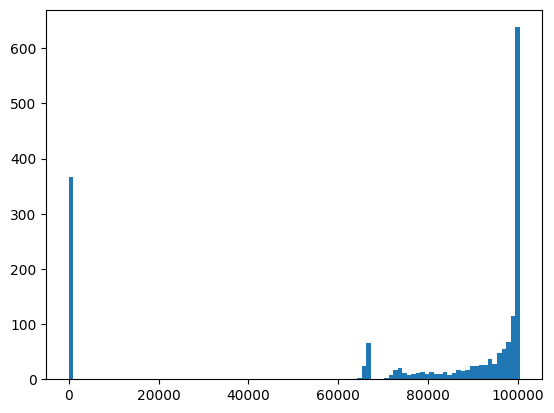

In [10]:
plt.hist(q_density, bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f19ebba7580>,
 'caps': [<matplotlib.lines.Line2D at 0x7f19ebba7ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f19ebba72e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f19ebb38040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f19ebb382e0>],
 'means': []}

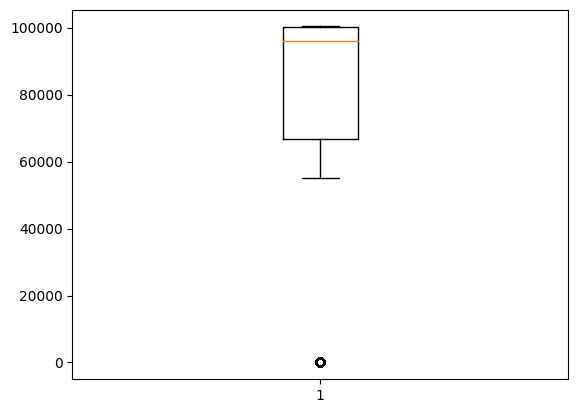

In [11]:
plt.boxplot(q_density)

Text(0.5, 0, 'Density of the regions')

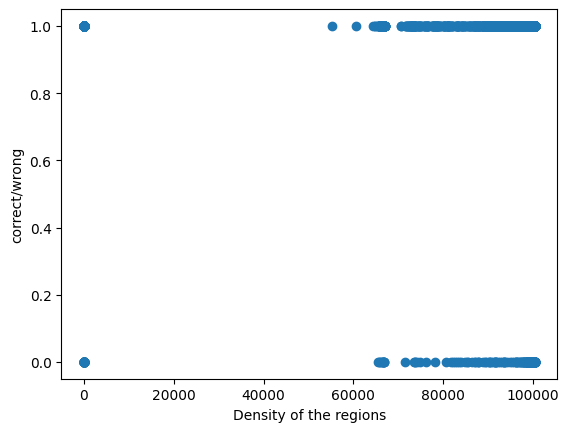

In [12]:
# density - eq
plt.scatter(q_density, q_eq_total.tolist())
plt.ylabel('correct/wrong')
plt.xlabel('Density of the regions')

Text(0.5, 0, 'Density of the regions')

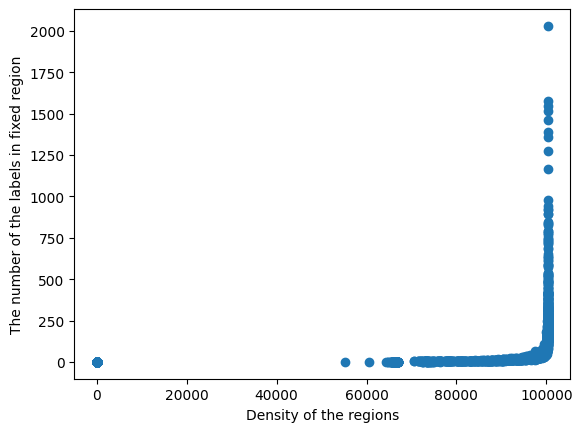

In [13]:
# density - the number of nearest y (label noise)
plt.scatter(q_density, q_n_nearest_y)
plt.ylabel('The number of the labels in fixed region')
plt.xlabel('Density of the regions')

# Low density region vs High density region

## Overall

In [14]:
num_zero = (np.array(q_density) == 0).sum()
num_zero

366

In [15]:
k = 32
low_density_idx = np.argsort(q_density)[:k].tolist()
high_density_idx = np.argsort(q_density)[-k:].tolist()

In [16]:
unorm = UnNormalize(mean=MEAN, std=STD)
low_den_samples = []
high_den_samples = []
for q_low_idx in low_density_idx:
    low_den_samples.append(unorm(q_x_total[q_low_idx]))
for q_high_idx in high_density_idx:
    high_den_samples.append(unorm(q_x_total[q_high_idx]))

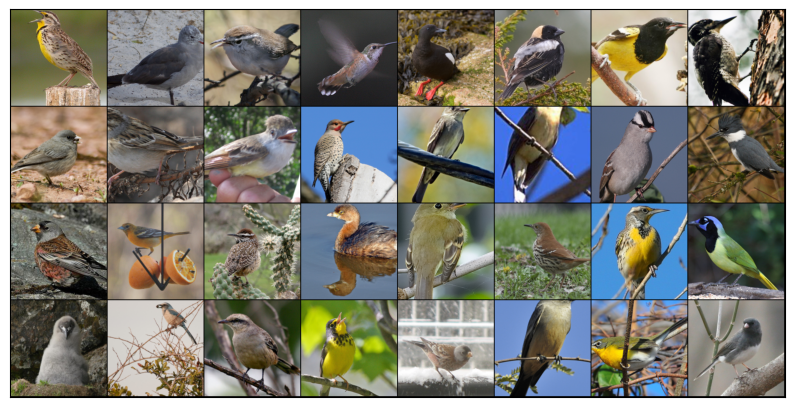

In [17]:
low_den_grid = make_grid(low_den_samples)
show(low_den_grid)

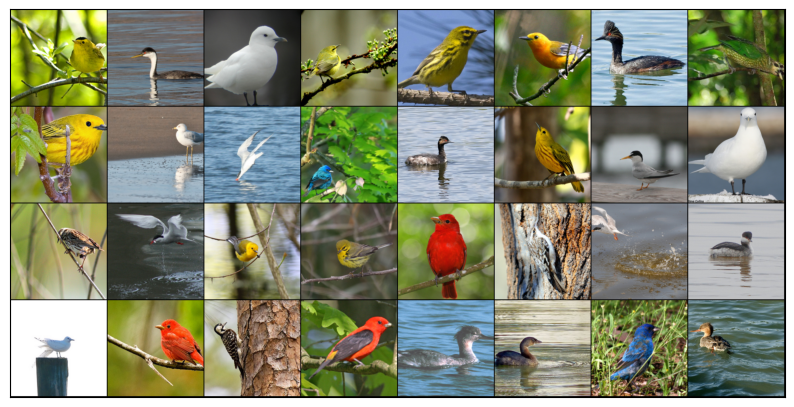

In [18]:
high_den_grid = make_grid(high_den_samples)
show(high_den_grid)

## 같은 label을 갖지만 region의 density 정도가 다른 경우 비교

(array([11.,  6.,  8.,  9.,  5.,  8.,  6., 11., 10., 10., 10.,  9.,  8.,
         8.,  8.,  8., 11.,  7.,  6.,  6.,  7.,  8., 11.,  4.,  7., 10.,
        11., 10.,  9.,  9.,  9., 12., 10., 12., 17., 12.,  9.,  9., 10.,
        11., 13., 10.,  8., 11.,  6.,  6.,  6.,  8.,  7., 12.,  6., 10.,
        10.,  9.,  5., 16.,  8.,  8., 10.,  6.,  5., 13.,  9.,  7.,  7.,
        12., 10.,  6., 17.,  7.,  8.,  8., 12., 11., 12.,  7., 14.,  3.,
         9., 15., 11.,  8., 10.,  8., 10., 10.,  5.,  9.,  9., 14., 15.,
        12.,  9.,  5., 12.,  7., 10., 13., 10.,  8., 11.,  9.,  6.,  3.,
        11.,  7., 10.,  6., 11., 11., 12., 11., 11.,  7., 13.,  8., 13.,
         8.,  6.,  7.,  7.,  9.,  4.,  7., 13.,  8.,  8.,  8., 10., 11.,
        13., 13., 10.,  6.,  8., 13.,  7., 11.,  8., 15.,  9.,  6.,  8.,
         9.,  9., 12.,  6.,  1., 11.,  7.,  7.,  8.,  7.,  6., 10.,  9.,
         9.,  6.,  6.,  4.,  8.,  6.,  7.,  9.,  9.,  7.,  8.,  9.,  9.,
         5.,  3.,  5., 11., 10.,  9.,  9.,  8.,  9.

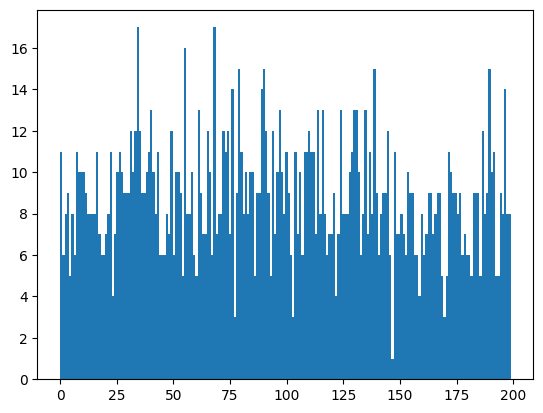

In [19]:
plt.hist(q_y_total, bins=200)

In [20]:
q_label = 1
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

167-th:       84280
315-th:       100183
354-th:       97635
933-th:       66778
1556-th:       0
1623-th:       66652


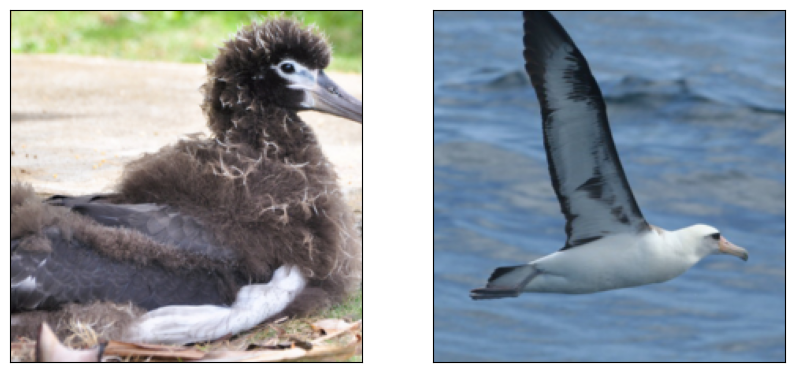

In [21]:
show_smaller([unorm(q_x_total[1556]), unorm(q_x_total[315])])

In [22]:
q_label = 2
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

80-th:       95543
288-th:       97337
342-th:       75795
444-th:       98393
554-th:       66223
744-th:       100352
753-th:       0
976-th:       98614


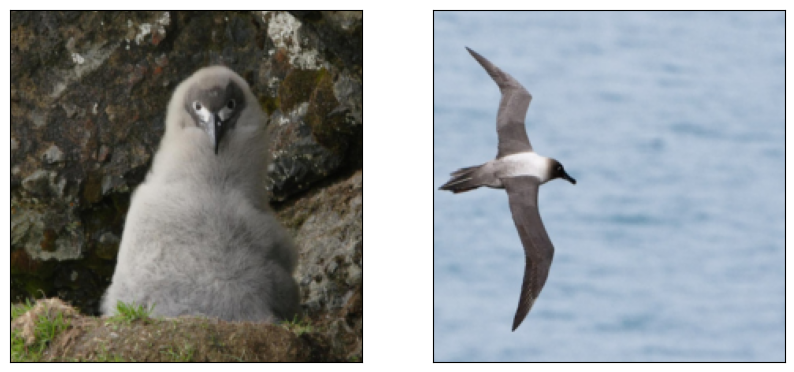

In [23]:
show_smaller([unorm(q_x_total[753]), unorm(q_x_total[744])])

In [24]:
q_label = 100
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

55-th:       100350
433-th:       96167
475-th:       100210
481-th:       89528
654-th:       85024
698-th:       92825
854-th:       99655
953-th:       92444
961-th:       99981
1129-th:       0
1216-th:       66907


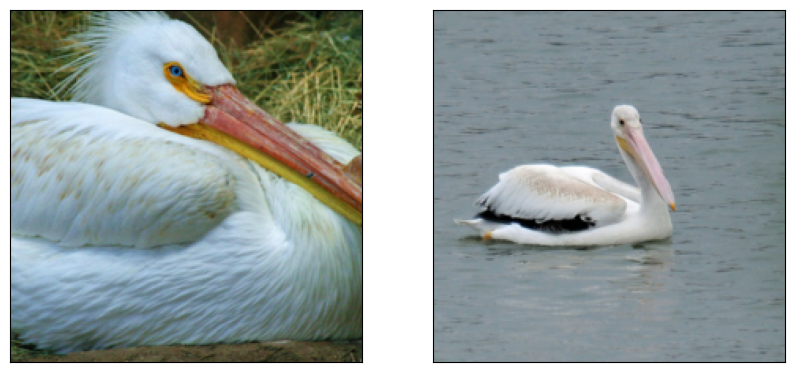

In [25]:
show_smaller([unorm(q_x_total[1129]), unorm(q_x_total[55])])

In [26]:
q_label = 190
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

196-th:       83170
208-th:       0
230-th:       0
322-th:       0
373-th:       0
411-th:       0
570-th:       89168
605-th:       75084
948-th:       91495
1160-th:       86995
1467-th:       78278
1471-th:       95979
1573-th:       87235
1719-th:       0
1732-th:       64829


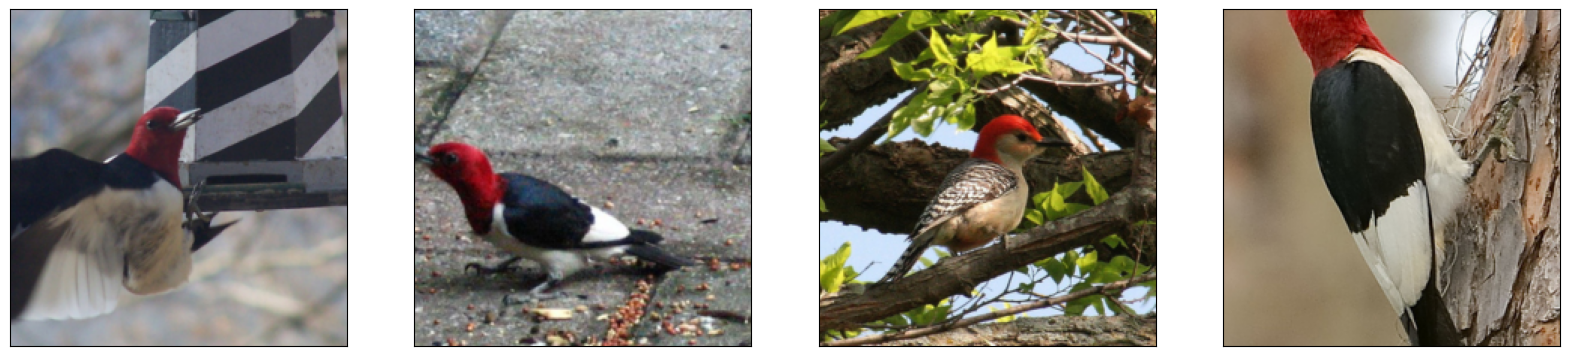

In [27]:
show_smaller([unorm(q_x_total[208]), unorm(q_x_total[1732]), unorm(q_x_total[948]), unorm(q_x_total[1471])]) # 948: wrong prediction

## 같은 prediction을 갖지만 region의 density 정도가 다른 경우 비교

(array([13.,  5.,  8.,  9.,  3.,  6.,  7., 11., 11., 10.,  8.,  8.,  7.,
         9.,  9.,  8., 12.,  7.,  6.,  7.,  9., 10.,  9.,  7.,  6., 10.,
         7., 10., 10., 14.,  7., 11., 13., 13., 18., 13.,  4.,  9., 10.,
         6., 11., 10.,  8., 11.,  6.,  9.,  7.,  8.,  6., 11.,  7., 10.,
        11.,  8.,  5., 17.,  8.,  7.,  7., 13.,  6., 12., 12.,  4.,  9.,
        12., 11.,  7., 14.,  8.,  5., 12.,  9., 13., 12.,  9., 14.,  2.,
        11., 14., 11.,  8., 10.,  4., 10.,  9.,  5.,  9.,  8., 13., 17.,
        12.,  9.,  7., 12.,  5., 10., 13.,  9.,  7., 11., 10., 11.,  4.,
         9.,  6., 12.,  4., 11., 11., 11., 11.,  8.,  5., 14.,  6., 11.,
        10.,  6.,  7.,  7., 10.,  6.,  7., 15.,  6.,  9.,  8., 11., 10.,
        12., 12.,  8.,  6.,  8., 12.,  8., 11.,  8., 15., 11.,  6.,  6.,
         8., 10., 12.,  6.,  1., 11.,  5.,  7.,  7.,  6.,  6., 11., 11.,
        10.,  5.,  6.,  4.,  7.,  6.,  8.,  9.,  8.,  8.,  7.,  9.,  8.,
         3.,  3.,  7., 15., 11.,  7.,  8.,  9.,  9.

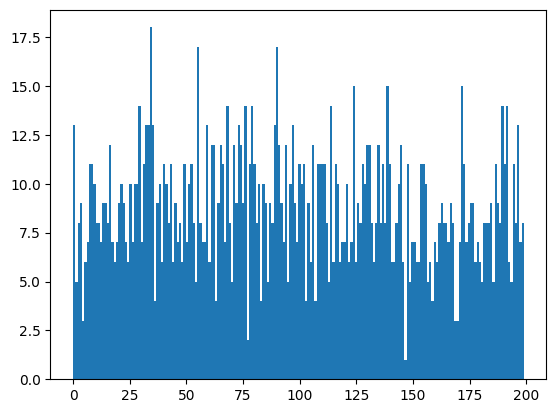

In [28]:
plt.hist(q_preds_total.cpu().detach(), bins=200)

In [29]:
q_pred = 2
q_pred_samples = torch.where(q_preds_total == q_pred)[0].tolist()
for i in q_pred_samples:
    print(f'{i}-th:       {q_density[i]}')

80-th:       95543
288-th:       97337
342-th:       75795
444-th:       98393
554-th:       66223
753-th:       0
976-th:       98614
1176-th:       100331


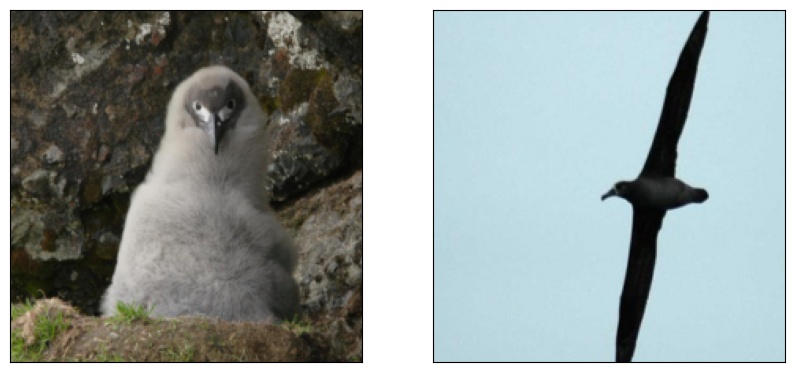

In [30]:
show_smaller([unorm(q_x_total[753]), unorm(q_x_total[1176])])

In [31]:
q_pred = 190
q_pred_samples = torch.where(q_preds_total == q_pred)[0].tolist()
for i in q_pred_samples:
    print(f'{i}-th:       {q_density[i]}')

196-th:       83170
208-th:       0
230-th:       0
322-th:       0
373-th:       0
411-th:       0
570-th:       89168
605-th:       75084
1160-th:       86995
1467-th:       78278
1471-th:       95979
1573-th:       87235
1719-th:       0
1732-th:       64829


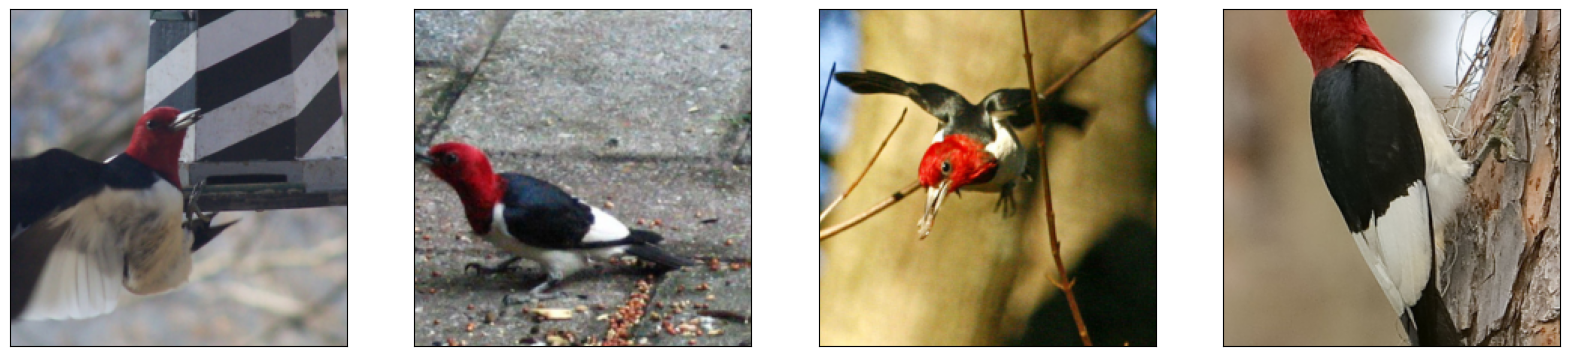

In [32]:
show_smaller([unorm(q_x_total[208]), unorm(q_x_total[1732]), unorm(q_x_total[570]), unorm(q_x_total[1471])])

## Region 관찰 (query 이미지를 중심으로)

### High-density region

In [33]:
high_density_idx[:3]

[671, 1641, 1519]

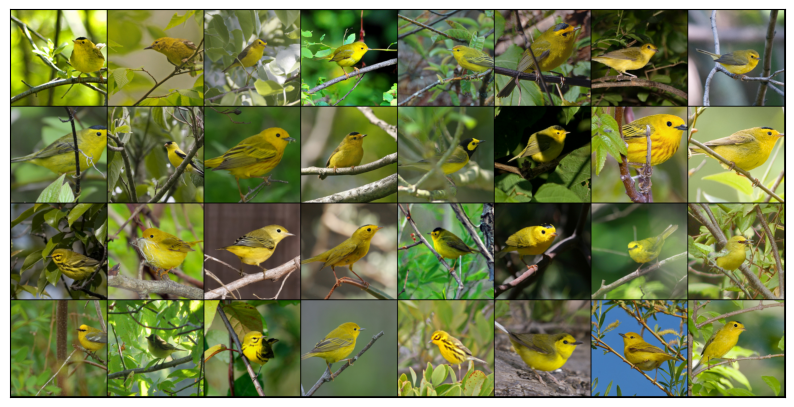

In [41]:
k = 31
h_idx = 671
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
grid = make_grid(img_list)
show(grid)

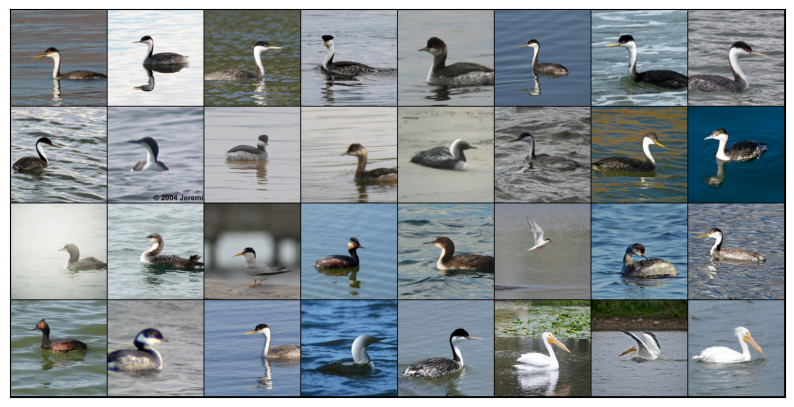

In [85]:
k = 31
h_idx = 1641
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
grid = make_grid(img_list)
show(grid)

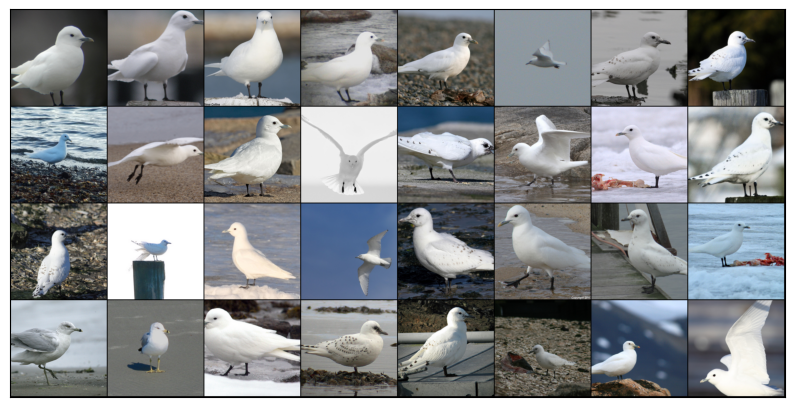

In [43]:
k = 31
h_idx = 1519
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
grid = make_grid(img_list)
show(grid)

### Low-density region

In [44]:
low_density_idx[:3]

[0, 839, 850]

In [46]:
q_density[0]

0

### Mid-density region

In [78]:
np.where((70000<np.array(q_density)) & (np.array(q_density)<75000))[0]

array([  89,  144,  168,  221,  239,  256,  277,  301,  324,  356,  395,
        403,  443,  518,  550,  552,  555,  613,  624,  687,  716,  771,
        788,  845,  873,  891,  911,  954, 1011, 1019, 1051, 1154, 1223,
       1228, 1257, 1277, 1301, 1319, 1338, 1355, 1372, 1408, 1412, 1433,
       1451, 1548, 1551, 1568, 1582, 1591, 1609, 1620, 1643, 1667, 1705])

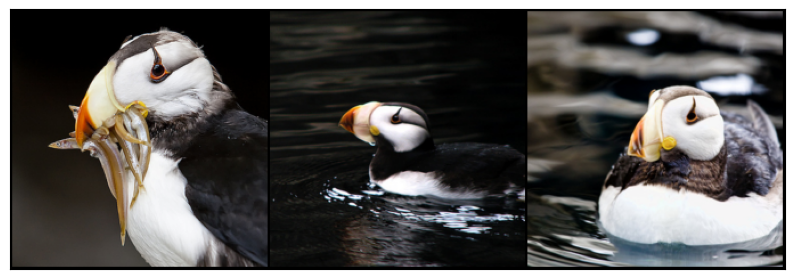

In [97]:
h_idx = 256 
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
grid = make_grid(img_list)
show(grid)

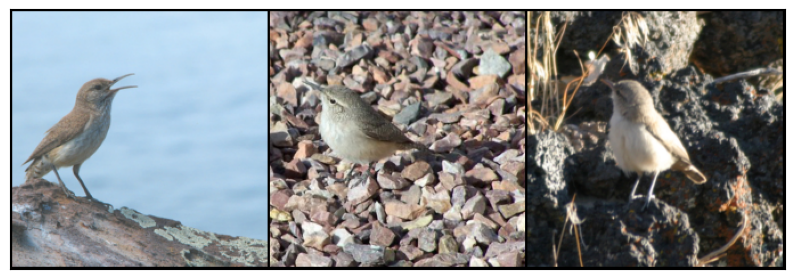

In [95]:
h_idx = 1019 
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
grid = make_grid(img_list)
show(grid)

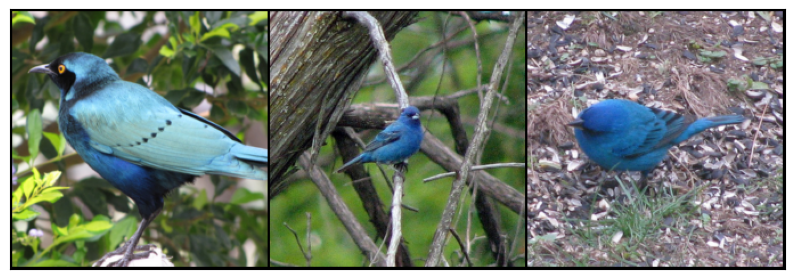

In [99]:
h_idx = 1705 
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
grid = make_grid(img_list)
show(grid)